Tarea 2 Minería de Datos

Tomás Cortés

Para separar los datos de training y testing se utilizó un código pyton que se adjuntará donde se separa utilizando un método aleatoreo.

In [1]:
import numpy as np
import pandas as pd
from random import random

In [2]:
df = pd.read_csv("training.csv")
df2 = pd.read_csv("training.csv")

In [3]:
for i in df:
    if len(df[i].unique()) < 3:
        print(i)
        print(df[i].unique())

Freq1_harmonics_rel_phase_0
[0.]
Freq2_harmonics_rel_phase_0
[0.]
Freq3_harmonics_rel_phase_0
[0.]


Dividimos los datos continuos segun su mediana, siendo 2 grupos de mayor a esta y menor o igual.
Esto ya que da buenos resultados.

para esto no consideramos el atributo Class
y eliminamos las variables:

Freq1_harmonics_rel_phase_0

Freq2_harmonics_rel_phase_0

Freq3_harmonics_rel_phase_0

ya que todos sus valores son 0


Todo esto lo incluimos en una función que se llamará "carga_y_proesamiento"
Donde dividimos todos los datos por intervalos

In [4]:
def carga_y_procesamiento(link):
    df = pd.read_csv(link)
    for i in range(1,4):
        df = df.drop([f'Freq{i}_harmonics_rel_phase_0'], axis=1)
        
    for i in df:
        if i != "Class":
            mediana = df[i].median()
            binds = np.array([np.NINF, mediana, np.Inf])
            #Creamos intervalos dividiendo con la mediana
            df[i] =  pd.cut(df[i], bins=[np.NINF, mediana, np.Inf])
    return df

In [5]:
def carga_test(link):
    df = pd.read_csv(link)
    return df

## Clase Nodo
Esta clase es muy importante, a partir de esta se crean los arboles y tiene las funciones requeridas para crearse utilizando las formulas de entropía y ganancia.


In [141]:
#Clases que se utilizarán

#
#YO NO HICE LA ACTIVIDAD, NO ESTOY REUTILIZANDO CODIGO
#
#
class Nodo:
    def __init__(self, df, target, father=None, category=None, value = None
                 , depth=0, max_depth=30, min_samples_split=100):
        self.df = df
        self.category = category#nombre variable
        self.value = value#valor de la variable
        self.father = father
        self.children = np.array([])
        self.target = target
        self.entropy = self.node_entropy()
        self.depth = depth
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.leaf = False
        self.prediction = ''
        
    def split_data_base(self, feature):
        """
        Este metodo recibe una feature y divide la base de datos en base a ella 
        generando los hijos del nodo.
        """
        return None 
    
    def node_entropy(self):
        entropy = 0
        values = self.df[self.target].unique()
        length = len(self.df[self.target])
        for val in values:
            repetitions = self.df[self.target].value_counts()[val]
            #Si length fuera 0, este for no recorre nada
            fraction = repetitions/length
            entropy += -fraction*np.log2(fraction)
        return entropy

    
    def var_entropy(self, var):
        values = self.df[self.target].unique()
        var_values = self.df[var].unique()
        final_entropy = 0
        df = self.df
        db_len = len(self.df[var])
        for var_att in var_values:
            entropy = 0
            aux = df[var][df[var]==var_att]
            length = len(aux)  
            
            for target_val in values:
                rep = len(aux[df[self.target] ==target_val]) 
                fraction = rep/length
                if fraction != 0 :
                    entropy += -fraction*np.log2(fraction)
            weigth = length/db_len
            final_entropy += weigth*entropy
        return final_entropy
    
    def best_variable(self):
        node_entropy = self.entropy
        best_var = ''
        gain = 0
        variables = self.df.drop([self.target], axis=1)
        
        for var in variables:
            g_var = node_entropy - self.var_entropy(var) 
            if  g_var > gain:
                gain = g_var
                best_var = var
        
        if gain == 0: 
            #no hay un nodo mejor y este se vuelve un nodo hoja
            self.select_leaf()
            return None
        
        return best_var
    
    def division(self):
        if self.max_depth == self.depth:
            self.select_leaf()
            return
            
            
        if len(self.df) < self.min_samples_split:
            self.select_leaf()
            return
            
            
        if len(self.df[self.target].unique()) <2:
            self.select_leaf()
            return
            
            
        best_var = self.best_variable()
        if best_var == None:
            self.select_leaf()
            return
        
        self.category = best_var
        elements = [x for x in self.df[best_var].unique()] #las nuevas db de los futuros nodos

        for element in  elements:
            n_df = self.df[self.df[best_var] == element]
            son = Nodo(n_df, self.target, father=self, category=best_var, value=element, depth = self.depth + 1, 
                        max_depth=self.max_depth)
            
            son.division()
            self.children = np.append(self.children, son)
            
                               
    def select_leaf(self):
        self.leaf = True
        
        self.prediction = self.df[self.target].mode()[0]
        
    def predict(self, sample):
        if self.leaf:
            if len(self.df) == 0:
                return None
            return self.prediction
        if sample[self.category] in self.children[0].value:           
            return self.children[0].predict(sample)
        else:
            return self.children[1].predict(sample)
        
    def add_to_dot(self, dot,father_id =False, my_id="C"):
        #Esta funcion se utiliza para agregar los nodos 
        #al visualizador de la librería grpahviz
        #se hace recursivamente para faciliarlo
        
        #sabemos que tienen todos los nodos a lo más 2 hijos
        value = str(self.value) if self.value != None else ""
        if self.leaf: 
            text = self.prediction
            shape = 'box'
            
        else:
            text =  self.category
            shape = 'ellipse'
            
        
        dot.node(my_id, text, shape=shape)
        if father_id:
            dot.edge(father_id, my_id, label=value)
                        
        if len(self.children) == 2:
            children_left = self.children[0]
            children_right = self.children[1]
            children_left.add_to_dot(dot, my_id, my_id + "L")
            children_right.add_to_dot(dot, my_id, my_id + "R")
        
        elif self.children:
            children_left = self.children[0]
            children_left.add_to_dot(dot, my_id, my_id + "L")
            
        
        

In [5]:
def simple_view_of_tree(nodo):
    cola = [nodo]
    n_n = nodo
    nivel = 0
    nivel_anterior = 0
    while n_n != None:
        n_n = cola.pop(0)
        nivel = n_n.depth
        if nivel > nivel_anterior:
            print()
            nivel_anterior = nivel
        print(n_n.category, n_n.value,n_n.prediction, end=" | ")
        for i in n_n.children:
            cola.append(i)
        if len(cola) == 0:
            break
    

In [18]:
class Forest:
    def __init__(self, df, target, n_estimators=800, max_depth=35
                 , bootstrap=True, min_samples_split=10, sample_size=10000, show=False):
        self.n_estimators= n_estimators
        self.target = target
        self.df = df
        self.bootstrap = bootstrap
        self.trees = self.poblate_forest(target, max_depth, min_samples_split, sample_size, show)
        
        
    def poblate_forest(self, target, max_depth, min_samples_split, sample_size, show=False):
        num_of_trees = self.n_estimators
        trees = []
        while num_of_trees:
            if self.bootstrap:
                dfs = self.df.sample(sample_size)
            else:
                dfs = self.df
            tree = Nodo(dfs ,"Class", max_depth=max_depth, min_samples_split=min_samples_split)
            tree.division()
            trees.append(tree)
            num_of_trees -= 1
            if show:
                print(f"Quedan {num_of_trees} arboles por plantar")
        return trees
            
    def predict(self, sample):
        answers = []
        for i in self.trees:
            answers.append(i.predict(sample))
        modes = {}
        for pred in answers:
            if pred in modes.keys():
                modes[pred] += 1
            else:
                modes[pred] = 1
        max_rep = 0
        mode = None
        for val, rep in modes.items():
            if max_rep<rep:
                mode = val
                max_rep = rep
        return mode

In [19]:
def fit(data, target, n_estimators=800, max_depth=20
        , min_samples_split=30, bootstrap=True, sample_size=10000, show=False):
    #toma los datos preprocesados y crea
    #los arboles de decisión correspondientes
    return Forest(data, target, n_estimators, max_depth, bootstrap, min_samples_split, sample_size, show)
    

### Primer test
Luego para ejecutar las funciones declaramos las variables:
basicas y en estas crearemos 20 arboles con profundidad máxima de 10, para que cada arbol de una buena estimación, esto utilizando 1609 datos para cada arbol, por lo que en total utiizaremos 32180 datos lo que es el 20% de nuestro training set, pero que por temas de tiempo no se dejó más

In [9]:
data = carga_y_procesamiento("training.csv")

In [168]:
sample_size = 0.1 #Fraccion de 
target = "Class"
n_estimators = 100
max_depth = 5
min_samples_split = 200
max_features = 20
bootstrap = True
sample_size = int(len(data)*sample_size)
print("tamaño: ", sample_size)

tamaño:  16094


In [164]:
print(sample_size)
forest = fit(data, target, n_estimators, max_depth, min_samples_split, bootstrap, sample_size, show = True)

16094
Quedan 99 arboles por plantar
Quedan 98 arboles por plantar
Quedan 97 arboles por plantar
Quedan 96 arboles por plantar
Quedan 95 arboles por plantar
Quedan 94 arboles por plantar
Quedan 93 arboles por plantar
Quedan 92 arboles por plantar
Quedan 91 arboles por plantar
Quedan 90 arboles por plantar
Quedan 89 arboles por plantar
Quedan 88 arboles por plantar
Quedan 87 arboles por plantar
Quedan 86 arboles por plantar
Quedan 85 arboles por plantar
Quedan 84 arboles por plantar
Quedan 83 arboles por plantar
Quedan 82 arboles por plantar
Quedan 81 arboles por plantar
Quedan 80 arboles por plantar
Quedan 79 arboles por plantar
Quedan 78 arboles por plantar
Quedan 77 arboles por plantar
Quedan 76 arboles por plantar
Quedan 75 arboles por plantar
Quedan 74 arboles por plantar
Quedan 73 arboles por plantar
Quedan 72 arboles por plantar
Quedan 71 arboles por plantar
Quedan 70 arboles por plantar
Quedan 69 arboles por plantar
Quedan 68 arboles por plantar
Quedan 67 arboles por plantar
Qued

In [13]:
def testing(test, forest):
    #retorna el porcentaje que estima correctamente 
    #los datos de testing
    buenas = 0
    malas = 0

    for i in range(len(test)):
        r = forest.predict(test.iloc[i,])
        if r == test.iloc[i,]["Class"]:
            buenas += 1
        else:
            malas += 1
    return buenas/(buenas + malas)

In [165]:
test = carga_test("testing.csv")

In [166]:
resultado = testing(test, forest)

In [167]:
print("Respuesta", round(resultado,4) *100, "%")

Respuesta 91.81 %


### Segundo test
En este test utilizaremos la mitad de datos por arbol, la máxima profundidad será 3, pero a diferencia del anterior, para ver si es conveniente tener muchos arboles menos precisos o pocos arboles más precisos.

In [21]:
sample_size = 0.005 #Fraccion de 
sample_size = int(len(data)*sample_size)
n_estimators = 100
max_depth = 3
big_forest = fit(data, target, n_estimators, max_depth, min_samples_split, bootstrap, sample_size, show=True)

Quedan 99 arboles por plantar
Quedan 98 arboles por plantar
Quedan 97 arboles por plantar
Quedan 96 arboles por plantar
Quedan 95 arboles por plantar
Quedan 94 arboles por plantar
Quedan 93 arboles por plantar
Quedan 92 arboles por plantar
Quedan 91 arboles por plantar
Quedan 90 arboles por plantar
Quedan 89 arboles por plantar
Quedan 88 arboles por plantar
Quedan 87 arboles por plantar
Quedan 86 arboles por plantar
Quedan 85 arboles por plantar
Quedan 84 arboles por plantar
Quedan 83 arboles por plantar
Quedan 82 arboles por plantar
Quedan 81 arboles por plantar
Quedan 80 arboles por plantar
Quedan 79 arboles por plantar
Quedan 78 arboles por plantar
Quedan 77 arboles por plantar
Quedan 76 arboles por plantar
Quedan 75 arboles por plantar
Quedan 74 arboles por plantar
Quedan 73 arboles por plantar
Quedan 72 arboles por plantar
Quedan 71 arboles por plantar
Quedan 70 arboles por plantar
Quedan 69 arboles por plantar
Quedan 68 arboles por plantar
Quedan 67 arboles por plantar
Quedan 66 

In [22]:
testing(test, big_forest)

0.8823855197240893

Podemos ver que al tener 20 arboles de profundidad 10 obtenemos un resultado bastante alto de 90%, esto gracias a que cada arbol por si solo ya debería ser un buen estimador y al tener más arboles la probabilidad de que todos se equivoquen baja rápidamente incluso utilizando pocos datos, lo que muestra como es un buen método de estimación el uso de random forest.
Luego viendo los resultados de el random forest con 100 arboles podemos ver que es un valor muy cercano pero peor, por lo que asumimos como obvio que con más arboles es mejor, pero llega a ser incluso mejor en tiempo y en resultados el tener menos arboles que utilizen más datos y mayor profundidad.

Luego para comparar
1ero se crearon 100 arboles con 16.000 datos cada arbol y el accuarcy fue de 90%
2 se crearon 20 con 1.600 y el accuarcy fue de 91.8%

De esto podemos concluir que si se siguen haciendo más arboles el porcentaje de correctas no subira tanto


# Visualización
Ahora que ya tenemos nuestro random forest, queremos visualizar un arbol, para este ejemplo utilizarmos un arbol de mayor profundidad que los otros y utilizaremos la librería graphviz.





In [142]:
target = "Class"
max_depth = 15
min_samples_split = int(len(data)*.001)
arbol = Nodo(data.sample(1800), target, max_depth=max_depth, min_samples_split=min_samples_split)

In [143]:
arbol.division()

In [147]:
testing(test, arbol)

0.8841980716461496

In [144]:
from graphviz import Digraph

dot = Digraph(comment='Tree')
arbol.add_to_dot(dot)

/home/tomas/.local/lib/python3.6/site-packages/ipykernel_launcher.py:155: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


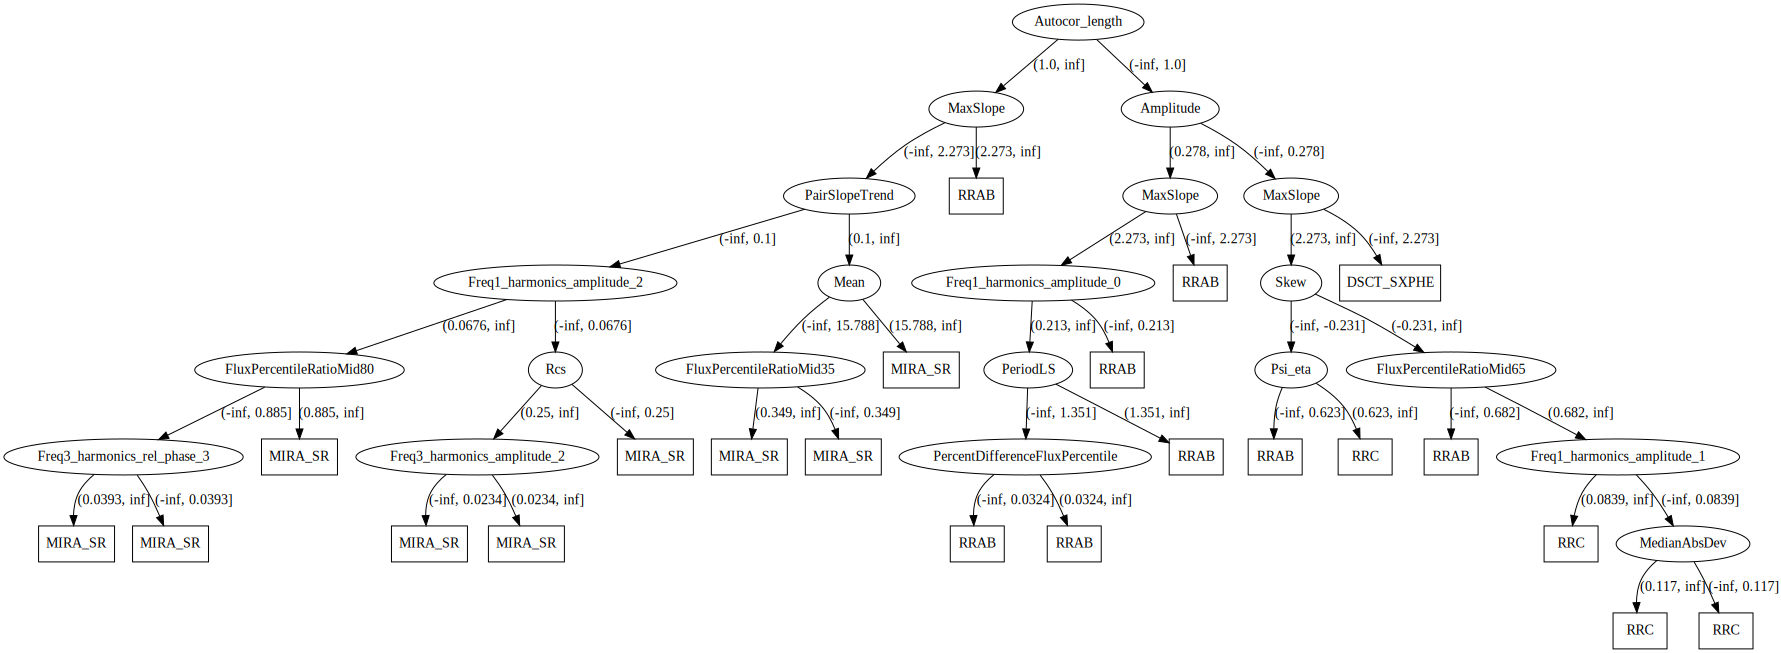

In [145]:
dot

In [149]:
dot.render('test-output/TomasCores_arbol.gv', view=True)  


'test-output/round-table.gv.pdf'

In [160]:
df["Class"].value_counts()

MIRA_SR       70504
RRAB          62559
RRC           16962
CEP            4929
DSCT_SXPHE     4191
T2CEP          1072
RRD             451
ACEP            205
ARRD             73
Name: Class, dtype: int64

Como podemos ver se genenra el arbol de decisión correctamente, y se ve como este es optimizable ya que hay ramas en las que desde cierto punto sin importar las otras comparaciones siempre dará el mismo resultado. en el caso que se enviará solucionado, en el nivel 2, el elegir el MaxSlope, si la tupla tiene ese dato menor a la mediana, el único resultado posible es MIRA_SR,  por lo que no es necesario recorrer el arbol.